In [1]:
import os
import sys
sys.path.append('..')

import torch
import pickle
import optuna
import numpy as np
import pandas as pd

from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP
from uncertain.BPR import ABPR, GPR

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt

os.chdir('ML_implicit')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data, implicit=True, users_on_test=1000)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
def unc_distribution(model):
    f, ax = plt.subplots(ncols=2)
    preds = model.predict(data.rand['users'], data.rand['items'])
    ax[0].hist(preds[1])
    ax[0].set_xlabel('Uncertainty')
    ax[0].set_ylabel('Density')
    ax[1].plot(preds[0], preds[1], 'o')
    ax[1].set_xlabel('Score')
    ax[1].set_ylabel('Uncertainty')
    f.tight_layout()

MovieLens data prepared: 6028 users, 3125 items.
502831 train, 52827 validation and 18688 test interactions.


In [1]:
import os
import sys
sys.path.append('..')

import torch
import pickle
import optuna
import numpy as np
import pandas as pd

from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP
from uncertain.BPR import ABPR, GPR

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt

os.chdir('RetailRocket')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_csv('events.csv')[['visitorid', 'itemid', 'timestamp']]
    data.columns = ['user', 'item', 'timestamps']
    data = Data(data, implicit=True, users_on_test=1000, distances=False)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)

Data prepared: 21716 users, 52073 items.
489513 train, 46533 validation and 4281 test interactions.


# Baseline (BPR)

In [3]:
def objective(trial):
    
    # Parameter setup
    dim = trial.suggest_int('dim', 20, 200)
    lr = trial.suggest_float('lr', 0.1, 10)
    wd = trial.suggest_float('wd', 0.000001, 0.0001)
    
    # Train model
    model = bprMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd)
    train(model, data, path='checkpoints/baseline', name=f'trial={len(study.trials)}-dim={dim}-wd={wd}-lr={lr}')
    return model.trainer.callback_metrics['val_loss']

file = 'tunning/baseline.pkl'
if os.path.exists(file):
    with open(file, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)
with open(file, 'wb') as f:
    pickle.dump(study, f, protocol=4)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 831 K 
1 | item_embeddings | Embedding | 431 K 
2 | rho_activation  | Softplus  | 0     
----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.052     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[I 2022-02-25 11:11:00,306] Trial 2 finished with value: 0.5564175844192505 and parameters: {'dim': 138, 'lr': 5.511283960383206, 'wd': 9.27976214149337e-05}. Best is trial 2 with value: 0.5564175844192505.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 518 K 
1 | item_embeddings | Embedding | 268 K 
2 | rho_activation  | Softplus  | 0     
----------------------------------------------
787 K     Trainable params
0         Non-trainable params
787 K     Total params
3.149     Tota

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
[I 2022-02-25 11:11:32,420] Trial 3 finished with value: 0.5223509073257446 and parameters: {'dim': 86, 'lr': 2.813279910336585, 'wd': 6.297855133425414e-05}. Best is trial 3 with value: 0.5223509073257446.


In [7]:
study.trials_dataframe().sort_values('value')

,number,value,datetime_start,datetime_complete,duration,params_dim,params_lr,params_wd,state
3,3,0.522351,2022-02-25 11:11:00.306935,2022-02-25 11:11:32.420639,0 days 00:00:32.113704,86,2.813280,0.000063,COMPLETE
2,2,0.556418,2022-02-25 11:10:22.794381,2022-02-25 11:11:00.306219,0 days 00:00:37.511838,138,5.511284,0.000093,COMPLETE
0,0,0.630366,2022-02-25 11:00:55.690843,2022-02-25 11:01:45.793772,0 days 00:00:50.102929,149,2.039424,0.000171,COMPLETE
1,1,0.693147,2022-02-25 11:01:45.794497,2022-02-25 11:02:11.256217,0 days 00:00:25.461720,55,6.781368,0.000283,COMPLETE


In [2]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = bprMF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
a = train(model, data, path='checkpoints/baseline', name=f'dim={50}-wd={0}-lr={1}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 301 K 
1 | item_embeddings | Embedding | 156 K 
2 | rho_activation  | Softplus  | 0     
----------------------------------------------
457 K     Trainable params
0         Non-trainable params
457 K     Total params
1.831     Total estimated model params size (MB)
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/vcoscrato/Documents/RecSys/MF/tests/ML_implicit/checkpoints/baseline exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


{'train_loss': tensor(0.1896), 'val_loss': tensor(0.3956)}

# AdaptiveBPR

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 301 K 
1 | item_embeddings | Embedding | 156 K 
2 | user_bias       | Embedding | 6.0 K 
3 | item_bias       | Embedding | 3.1 K 
4 | rho_activation  | Softplus  | 0     
----------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.867     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


  0%|          | 0/1000 [00:00<?, ?it/s]

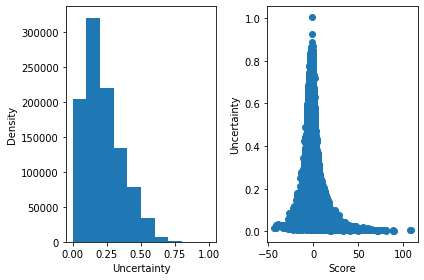

In [3]:
for dim in [50]:
    for wd in [0]:
        for lr in [5]:
            model = biasMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=ABPR(log_scale=False))
            train(model, data, path='checkpoints/ABPR', name=f'dim={dim}-wd={wd}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ABPR')}
model = biasMF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0, loss=ABPR(log_scale=False))
model = model.load_from_checkpoint(os.path.join('checkpoints/ABPR', min(files, key=files.get)))
test_implicit(model, data, name='ABPR', max_k=10, use_baseline=False)
unc_distribution(model)

## Log scale

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 301 K 
1 | item_embeddings | Embedding | 156 K 
2 | user_bias       | Embedding | 6.0 K 
3 | item_bias       | Embedding | 3.1 K 
4 | rho_activation  | Softplus  | 0     
----------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.867     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior

  0%|          | 0/1000 [00:00<?, ?it/s]

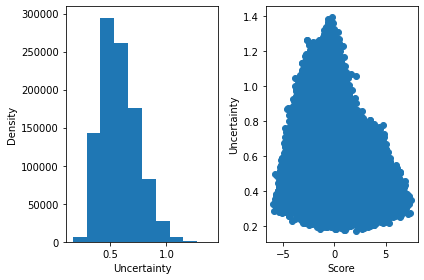

In [4]:
for dim in [50]:
    for wd in [0]:
        for lr in [1]:
            model = biasMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=ABPR(log_scale=True))
            train(model, data, path='checkpoints/ABPRlog', name=f'dim={dim}-wd={wd}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ABPRlog')}
model = biasMF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0, loss=ABPR(log_scale=True))
model = model.load_from_checkpoint(os.path.join('checkpoints/ABPRlog', min(files, key=files.get)))
test_implicit(model, data, name='ABPRlog', max_k=10, use_baseline=False)
unc_distribution(model)

# Gaussian Personalized Ranking (GPR)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 301 K 
1 | item_embeddings | Embedding | 156 K 
2 | user_bias       | Embedding | 6.0 K 
3 | item_bias       | Embedding | 3.1 K 
4 | rho_activation  | Softplus  | 0     
----------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.867     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


  0%|          | 0/1000 [00:00<?, ?it/s]

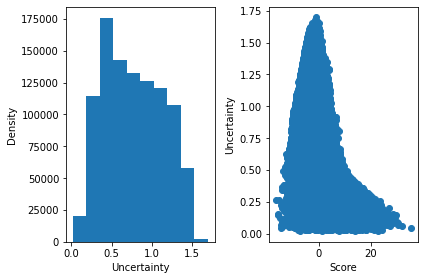

In [5]:
for dim in [50]:
    for wd in [0]:
        for lr in [5]:
            model = biasMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=GPR(log_scale=False))
            train(model, data, path='checkpoints/GPR', name=f'dim={dim}-wd={wd}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/GPR')}
model = biasMF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0, loss=GPR(log_scale=False))
model = model.load_from_checkpoint(os.path.join('checkpoints/GPR', min(files, key=files.get)))
test_implicit(model, data, name='GPR', max_k=10, use_baseline=False)
unc_distribution(model)

## Log scale

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 301 K 
1 | item_embeddings | Embedding | 156 K 
2 | user_bias       | Embedding | 6.0 K 
3 | item_bias       | Embedding | 3.1 K 
4 | rho_activation  | Softplus  | 0     
----------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.867     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


  0%|          | 0/1000 [00:00<?, ?it/s]

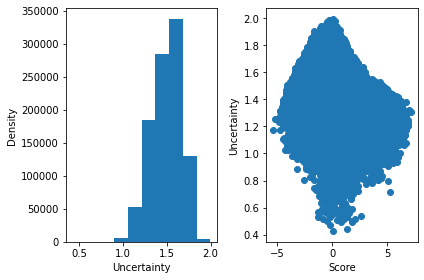

In [6]:
for dim in [50]:
    for wd in [0]:
        for lr in [1]:
            model = biasMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=GPR(log_scale=True))
            train(model, data, path='checkpoints/GPRlog', name=f'dim={dim}-wd={wd}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/GPRlog')}
model = biasMF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0, loss=GPR(log_scale=True))
model = model.load_from_checkpoint(os.path.join('checkpoints/GPRlog', min(files, key=files.get)))
test_implicit(model, data, name='GPRlog', max_k=10, use_baseline=False)
unc_distribution(model)

# DoubleMF

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params
--------------------------------------------------
0 | user_embeddings     | Embedding | 301 K 
1 | item_embeddings     | Embedding | 156 K 
2 | user_embeddings_rho | Embedding | 301 K 
3 | item_embeddings_rho | Embedding | 156 K 
4 | rho_activation      | Softplus  | 0     
--------------------------------------------------
915 K     Trainable params
0         Non-trainable params
915 K     Total params
3.661     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


  0%|          | 0/1000 [00:00<?, ?it/s]

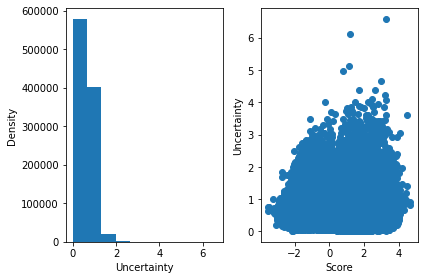

In [7]:
for dim in [50]:
    for wd in [0]:
        for lr in [1]:
            model = TwoWayMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=GPR(log_scale=True))
            train(model, data, path='checkpoints/GPRlog_MF', name=f'dim={dim}-wd={wd}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/GPRlog_MF')}
model = TwoWayMF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0, loss=GPR(log_scale=True))
model = model.load_from_checkpoint(os.path.join('checkpoints/GPRlog_MF', min(files, key=files.get)))
test_implicit(model, data, name='GPRlog_MF', max_k=10, use_baseline=False)
unc_distribution(model)

# GMF

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 301 K 
1 | item_embeddings | Embedding | 156 K 
2 | linear          | Linear    | 100   
3 | rho_activation  | Softplus  | 0     
----------------------------------------------
457 K     Trainable params
0         Non-trainable params
457 K     Total params
1.831     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


  0%|          | 0/1000 [00:00<?, ?it/s]

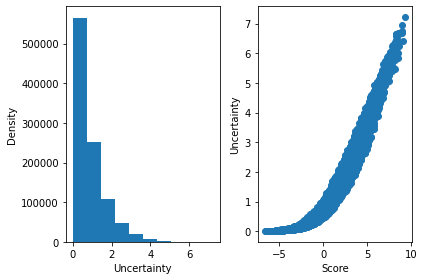

In [8]:
for dim in [50]:
    for wd in [0]:
        for lr in [1]:
            model = bprGMF(data.n_user, data.n_item, embedding_dim=dim, lr=lr, weight_decay=wd, loss=GPR(log_scale=True))
            train(model, data, path='checkpoints/GPRlog_GMF', name=f'dim={dim}-wd={wd}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/GPRlog_GMF')}
model = bprGMF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0, loss=GPR(log_scale=True))
model = model.load_from_checkpoint(os.path.join('checkpoints/GPRlog_GMF', min(files, key=files.get)))
test_implicit(model, data, name='GPRlog_GMF', max_k=10, use_baseline=False)
unc_distribution(model)

# Results

In [9]:
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
results = dict(sorted(results.items()))
NDCG = [results[a]['accuracy']['NDCG'][-1] for a in results]
RRI = [results[a]['uncertainty']['RRI'][-1] if 'PR' in a else np.NaN for a in results]
UncertainNDCG = [results[a]['uncertain_accuracy']['NDCG'][-1] if 'PR' in a else np.NaN for a in results]
interesting_stuff = pd.DataFrame({'NDCG': NDCG, 'RRI': RRI, 'UncertainNDCG': UncertainNDCG}, index=results)
interesting_stuff

,NDCG,RRI,UncertainNDCG
ABPR,0.102350,0.125430,0.101828
ABPRlog,0.112470,0.091713,0.115746
Baseline,0.114694,NaN,NaN
GPR,0.104862,0.120512,0.106920
GPRlog,0.112496,0.124585,0.118186
GPRlog GMF,0.119484,-0.332069,0.122427
GPRlog MF,0.113772,0.050468,0.113550
